In [10]:
import sys
import json
import pickle
import pyspark
from functools import reduce
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import udf, mean, lit, stddev, col, expr, when
from pyspark.sql.types import DoubleType, ArrayType, ShortType, LongType, IntegerType
import pandas as pd
from collections import OrderedDict
from datetime import date
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from pyspark.storagelevel import StorageLevel

from azureml.api.schema.dataTypes import DataTypes
from azureml.api.schema.sampleDefinition import SampleDefinition
from azureml.api.realtime.services import generate_schema

In [11]:
STORAGE_ACCOUNT_SUFFIX = 'core.windows.net'
STORAGE_ACCOUNT_NAME = os.environ['STORAGE_ACCOUNT_NAME']
TELEMETRY_CONTAINER_NAME = 'telemetry'

wasbUrlInput = "wasb://{0}@{1}.blob.{2}/*/*/*/*/*/*/*".format(
#wasbUrlInput = "wasb://{0}@{1}.blob.{2}/*/00/2018/03/26/22/*".format(
            TELEMETRY_CONTAINER_NAME,
            STORAGE_ACCOUNT_NAME,
            STORAGE_ACCOUNT_SUFFIX)

sc = SparkContext.getOrCreate()

hc = sc._jsc.hadoopConfiguration()
hc.set("avro.mapred.ignore.inputs.without.extension", "false")
# hc.set("fs.azure.account.key.{}.blob.core.windows.net".format(STORAGE_ACCOUNT_NAME), STORAGE_ACCOUNT_KEY)

sql = SQLContext.getOrCreate(sc)

df = sql.read.format("com.databricks.spark.avro").load(wasbUrlInput)

df.printSchema()

root
 |-- EnqueuedTimeUtc: string (nullable = true)
 |-- Properties: map (nullable = true)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)
 |-- SystemProperties: map (nullable = true)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)
 |-- Body: binary (nullable = true)



In [4]:
print('Message count: {0}'.format(df.count()))

Message count: 8317


In [12]:
sample_rate = 8000

def extract_double(c):
    return udf(lambda x: float(pickle.loads(x)[c]), DoubleType())

def extract_array(c):
    return udf(lambda x: pickle.loads(x)[c], ArrayType(ShortType()))

def extract_amplitude_spectrum(c):
    def m(x):
        ampl = np.abs(np.fft.fft(pickle.loads(x)[c])) / sample_rate
        return ampl[:sample_rate // 2 + 1].tolist()
                      
    return udf(m, ArrayType(DoubleType()))

def extract_dominant_frequencies(index):
    def m(ff):
        freq = np.fft.fftfreq(sample_rate, d = 1/sample_rate)[:sample_rate // 2 + 1]
        return [float(f[index]) for f in sorted(list(zip(freq, ff)), key = lambda x: x[1], reverse = True)]
    
    return udf(m, ArrayType(DoubleType()))


dfa = (df
       .withColumn('machineID', df.SystemProperties['connectionDeviceId'])
       .withColumn("ambient_temperature", extract_double("ambient_temperature")(df.Body))
       .withColumn("ambient_pressure", extract_double("ambient_pressure")(df.Body))
       .withColumn("speed", extract_double("speed")(df.Body))
       .withColumn("temperature", extract_double("temperature")(df.Body))
       .withColumn("pressure", extract_double("pressure")(df.Body))
       .withColumn("vibration", extract_array("vibration")(df.Body))
       .withColumn("fft", extract_amplitude_spectrum("vibration")(df.Body))
       .drop('Properties', 'SystemProperties', 'Body'))

dfa = (dfa
       .withColumn("dominant_frequencies", extract_dominant_frequencies(0)(dfa.fft))
       .withColumn("dominant_frequencies_amplitudes", extract_dominant_frequencies(1)(dfa.fft))
       .where(dfa.speed > 0))

In [13]:
#df.unpersist()
dfa.printSchema()
input_features = ["ambient_temperature", "ambient_pressure", "speed", "temperature", "pressure", "vibration"]
input_sample = dfa.limit(5).select(input_features)

# define the input data frame
inputs = {"input_df": SampleDefinition(DataTypes.SPARK, input_sample)}

def run(input_df):
    pass

json_schema = generate_schema(run_func=run, inputs=inputs, filepath='../service_schema.json')

root
 |-- EnqueuedTimeUtc: string (nullable = true)
 |-- machineID: string (nullable = true)
 |-- ambient_temperature: double (nullable = true)
 |-- ambient_pressure: double (nullable = true)
 |-- speed: double (nullable = true)
 |-- temperature: double (nullable = true)
 |-- pressure: double (nullable = true)
 |-- vibration: array (nullable = true)
 |    |-- element: short (containsNull = true)
 |-- fft: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- dominant_frequencies: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- dominant_frequencies_amplitudes: array (nullable = true)
 |    |-- element: double (containsNull = true)



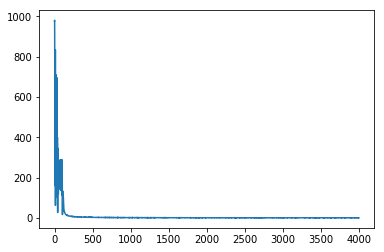

4341


In [17]:
#dfa.limit(5).toPandas()
plt.plot(dfa.first().fft)
plt.show()

In [18]:
k = dfa.where(dfa.machineID == 'MACHINE-000').orderBy('EnqueuedTimeUtc').take(20)
k = np.concatenate(np.array([x.vibration for x in k]))

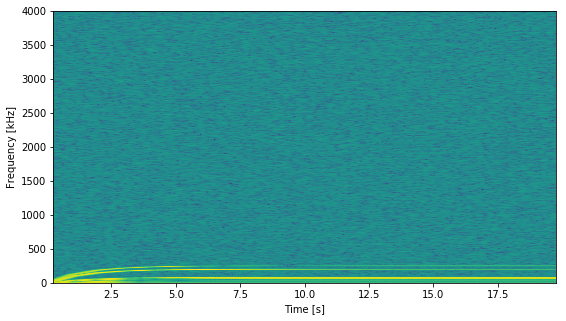

In [19]:
freqs, times, Sx = signal.spectrogram(k, fs=8000, window='hanning',
                                      nperseg=4096, noverlap=4096 - 100,
                                      detrend=False, scaling='spectrum')
f, ax = plt.subplots(figsize=(9, 5))
ax.pcolormesh(times, freqs, 10 * np.log10(Sx), cmap='viridis')
ax.set_ylabel('Frequency [kHz]')
ax.set_xlabel('Time [s]')
plt.show()

In [20]:
freq = np.fft.fftfreq(sample_rate, d = 1/sample_rate)[:sample_rate // 2 + 1]
max_freq = sorted(list(zip(freq, dfa.sample(False, 0.1, seed=0).first().fft)), key = lambda x: x[1], reverse = True)[10 : ]
pdf = pd.DataFrame.from_records(max_freq)
pdf.head()

,0,1
0,16.0,429.992935
1,65.0,313.893159
2,82.0,235.458461
3,250.0,233.275225
4,197.0,228.852200


In [21]:
frequency_features = 3
dfa = reduce(lambda _df, i: _df.withColumn('f{0}'.format(i), _df.dominant_frequencies[i]), range(frequency_features), dfa)
dfa = reduce(lambda _df, i: _df.withColumn('a{0}'.format(i), _df.dominant_frequencies_amplitudes[i]), range(frequency_features), dfa)
dfa = dfa.drop('vibration', 'fft', 'dominant_frequencies', 'dominant_frequencies_amplitudes')
dfa.persist(StorageLevel.MEMORY_AND_DISK)

DataFrame[EnqueuedTimeUtc: string, machineID: string, ambient_temperature: double, ambient_pressure: double, speed: double, temperature: double, pressure: double, f0: double, f1: double, f2: double, a0: double, a1: double, a2: double]

In [22]:
dependent_features = [c for c in dfa.columns if c not in ['machineID', 'EnqueuedTimeUtc', 'speed', 'ambient_pressure', 'ambient_temperature']]
dfa = reduce(lambda _df, f: _df.withColumn('{0}_n'.format(f), col(f) / col('speed')), dependent_features, dfa)

In [23]:
wasbUrlOutput = "wasb://{0}@{1}.blob.{2}/features.parquet".format(
            'intermediate',
            STORAGE_ACCOUNT_NAME,
            STORAGE_ACCOUNT_SUFFIX)

dfa.write.parquet(wasbUrlOutput, mode="overwrite")

dfa.limit(5).toPandas().head()

,EnqueuedTimeUtc,machineID,ambient_temperature,ambient_pressure,speed,temperature,pressure,f0,f1,f2,...,a1,a2,temperature_n,pressure_n,f0_n,f1_n,f2_n,a0_n,a1_n,a2_n
0,2018-03-26T22:24:55.3720000Z,MACHINE-000,20.0,101.0,512.50,20.160156,243.065000,1.0,0.0,2.0,...,976.131750,904.610400,0.039337,0.474273,0.001951,0.000000,0.003902,1.912976,1.904647,1.765093
1,2018-03-26T22:24:55.4970000Z,MACHINE-007,20.0,101.0,503.00,20.152409,237.564500,1.0,0.0,2.0,...,964.388875,904.635240,0.040064,0.472295,0.001988,0.000000,0.003976,1.932882,1.917274,1.798480
2,2018-03-26T22:24:55.5130000Z,MACHINE-005,20.0,101.0,700.50,20.350600,374.195000,1.0,0.0,2.0,...,816.813875,792.855859,0.029052,0.534183,0.001428,0.000000,0.002855,1.171751,1.166044,1.131843
3,2018-03-26T22:24:56.4030000Z,MACHINE-000,20.0,101.0,768.75,20.596152,541.594072,46.0,44.0,49.0,...,566.666370,504.323983,0.026792,0.704513,0.059837,0.057236,0.063740,0.817427,0.737127,0.656031
4,2018-03-26T22:24:56.5280000Z,MACHINE-005,20.0,101.0,1050.75,21.240842,918.684719,61.0,68.0,32.0,...,508.368448,498.560883,0.020215,0.874313,0.058054,0.064716,0.030454,0.504544,0.483815,0.474481
